## stacking 模型

为什么需要模型融合：多个学习器进行结合，常可获得比单一学习器显著优越的泛化性能。 --《机器学习 周志华》

stacking模型融合策略：我们做两层，第一层模型是lgb和xgb，第二层模型是lr(逻辑回归)
第一层模型的作用：将数据训练并预测，并将训练结果和预测结果作为特征
第二层模型的作用：将第一层的两个模型的训练结果和预测结果作为训练集和预测集，对数据进行训练和预测

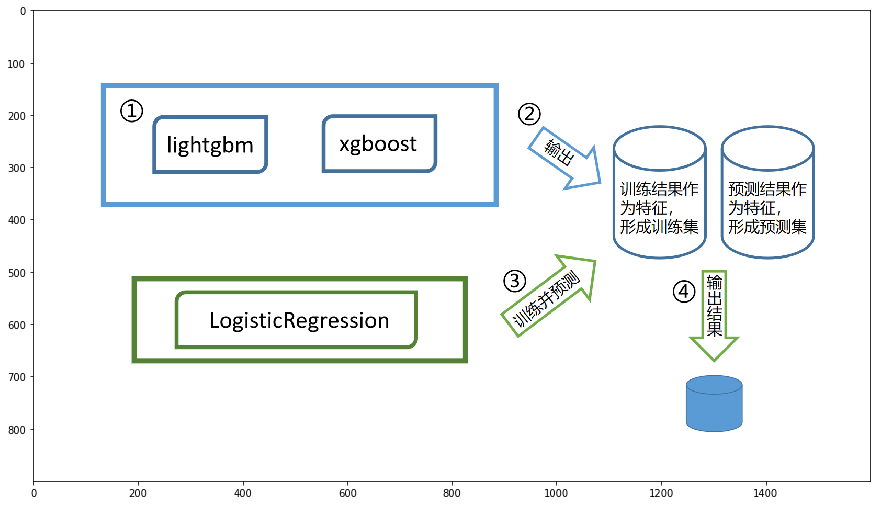

In [10]:
import matplotlib.pyplot as plt
stacking_plt = plt.imread('../doc/assets/model_fusion.png')  # 导入图片
plt.figure(figsize=(15, 15))  # 图片大小
plt.imshow(stacking_plt)  # 打印图片

In [80]:
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn.metrics import roc_auc_score  # roc

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/train.csv')

In [3]:
train.shape, test.shape

((100000, 300), (100000, 300))

In [4]:
train = train.fillna(-999) ### 填充特殊值
test = test.fillna(-999)

In [5]:
feats = [x for x in train.columns if x not in ['id','label']]

In [12]:
y = train['label'].values
X = train[feats].values
test_id = test['id'].values
X_test = test[feats].values
y_test  = test['label'].values

In [9]:
# 载入五折工具及各个模型
from sklearn.model_selection import StratifiedKFold  # 数据切分、分层五折验证包
import lightgbm as lgb  # lgb模型 ,安装的方法是在anaconda promote里，直接pip install lightgbm 即可
import xgboost as xgb  # xgb模型，安装的方法是在anaconda promote里，直接pip install xgboost 即可，和lightgbm一样
# 设置skf
data_seed = 2020
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=data_seed)

In [10]:
# lgb和xgb的参数
lgb_params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.06,
    'num_leaves': 31,
    'max_depth': -1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'feature_fraction_seed': 300, ### 特征抽样的随机种子
    'bagging_seed': 3, ### 数据抽样的随机种子,取10个不同的，然后对结果求平均,todo:求出10个结果，然后求平均
    #'is_unbalance': True   #### 第一种方法：设置is_unbalance为True，表明传入的数据集是类别不平衡的
    #'scale_pos_weight': 98145/1855###负样本数量/正样本数量 -> scale_pos_weight * 正样本 == 负样本
}
xgb_params = {
    'booster': 'gbtree',  ##提升类型
    'objective': 'binary:logistic',  ###目标函数
    'eval_metric': 'auc',  ##评价函数
    'eta': 0.1,  ### 学习率 ，一般0.0几
    'max_depth': 6,  ###树最大深度
    'min_child_weight': 1,  ###最小样本二阶梯度权重, 取值是整数
    'subsample': 1.0,  ###训练数据采样 ,取值0.0~1.0之间
    'colsample_bytree': 1.0,  ###训练特征采样，取值0.0~1.0之间
    'lambda': 1,  ## l2正则，取值是整数
    'alpha': 0,   ### l1正则，取值整数
    'silent': 1   ### 取值1控制xgboost训练信息不输出
}

In [36]:
blend_train = pd.DataFrame()  # 定义df数据，以便做融合
blend_test = pd.DataFrame()  # 定义df数据，以便做融合

In [15]:
# 训练lgb，用作第一层模型中的其中一个
test_pred_lgb = 0  # 预测结果存放对象
cv_score_lgb = []  # 存放每次auc的对象
train_feats = np.zeros(X.shape[0])  # 整体训练的样本数量
for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print('training fold: ', idx + 1)  # 遍历的第几次
    train_x, valid_x = X[train_idx], X[test_idx]  # 拆分成训练集和验证集
    train_y, valid_y = y[train_idx], y[test_idx]  # 拆分成训练集和验证集
    dtrain = lgb.Dataset(train_x, train_y, feature_name=feats)  # 组成训练集
    dvalid = lgb.Dataset(valid_x, valid_y, feature_name=feats)  # 组成验证集
    model = lgb.train(lgb_params, dtrain, num_boost_round=2000, valid_sets=dvalid, early_stopping_rounds=50, verbose_eval=50)  # 定义lgb模型

    valid_pred = model.predict(valid_x, num_iteration=model.best_iteration)  # 当前模型最佳参数并预测，num_iteration：选择最优的lgb
    train_feats[test_idx] = valid_pred  # 每次把验证集的结果填入，做训练的结果集，由于是5折，所以每次都是1/5的数据，把它们当作lgb训练集特征
    auc_score = roc_auc_score(valid_y, valid_pred)  # 计算auc
    print('auc score: ', auc_score)
    cv_score_lgb.append(auc_score)  # 存放验证集auc值
    test_pred_lgb += model.predict(X_test, num_iteration=model.best_iteration)  # 预测结果并累加，做预测的结果集，把它们当作lgb测试集当作特征

training fold:  1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.971437
[100]	valid_0's auc: 0.976224
[150]	valid_0's auc: 0.977292
[200]	valid_0's auc: 0.977833
[250]	valid_0's auc: 0.977789
Early stopping, best iteration is:
[233]	valid_0's auc: 0.977946
auc score:  0.9779461572822764
training fold:  2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.976491
[100]	valid_0's auc: 0.977797
[150]	valid_0's auc: 0.9778
Early stopping, best iteration is:
[113]	valid_0's auc: 0.978142
auc score:  0.9781421102694882
training fold:  3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.976192
[100]	valid_0's auc: 0.978029
[150]	valid_0's auc: 0.979202
[200]	valid_0's auc: 0.979367
[250]	valid_0's auc: 0.979628
[300]	valid_0's auc: 0.97977
[350]	valid_0's auc: 0.979687
Early stopping, best iteration is:
[311]	valid_0's auc: 0.979878
auc score:  0.9798779488899133
training fold:  4
Training unti

In [16]:
train_feats  # 训练的结果

array([1.69777395e-04, 7.61534609e-04, 4.87054815e-03, ...,
       5.55546514e-02, 3.93865215e-02, 5.10414655e-01])

In [20]:
test_pred_lgb /= 5
test_pred_lgb  # 测试的结果，由于测试的结果是5折每次的累加，所以需要除于5

array([3.62077794e-04, 6.29276400e-04, 3.35815479e-03, ...,
       4.64100502e-01, 3.11100442e-01, 6.07412241e-01])

In [37]:
# 将训练结果和预测结果加入到blend数据集
blend_train['lgb_feat'] = train_feats
blend_test['lgb_feat'] = test_pred_lgb

In [22]:
# 训练xgb，用作第一层模型中的其中一个
test_pred_xgb = 0 # 预测结果存放对象
cv_score_xgb = []  # 存放每次auc的对象
train_feats_xgb = np.zeros(X.shape[0])  # 整体训练的样本数量
for idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print('training fold: ', idx + 1) # 遍历的第几次
    train_x, valid_x = X[train_idx], X[test_idx]  # 拆分成训练集和验证集
    train_y, valid_y = y[train_idx], y[test_idx]  # 拆分成训练集和验证集
    dtrain = xgb.DMatrix(train_x, train_y, feature_names=feats)  # 组成训练集
    dvalid = xgb.DMatrix(valid_x, valid_y, feature_names=feats)  # 组成验证集
    watchlist = [(dvalid, 'eval')]
    model = xgb.train(xgb_params, dtrain, num_boost_round=2000, evals=watchlist, early_stopping_rounds=50, verbose_eval=50)  # 定义xgb模型

    valid_pred = model.predict(dvalid, ntree_limit=model.best_iteration)  # 当前模型最佳参数并预测，ntree_limit：选择最优的xgb
    train_feats_xgb[test_idx] = valid_pred  # 每次把验证集的结果填入，做训练的结果集，由于是5折，所以每次都是1/5的数据
    auc_score = roc_auc_score(valid_y, valid_pred)  # 计算auc
    print('auc score: ', auc_score)
    cv_score_xgb.append(auc_score)  # 存放验证集auc值
    dtest = xgb.DMatrix(X_test,feature_names=feats)  ##同时指定特征名字
    test_pred_xgb += model.predict(dtest, ntree_limit=model.best_iteration)  # 预测结果并累加，做预测的结果集

training fold:  1
[0]	eval-auc:0.902923
Will train until eval-auc hasn't improved in 50 rounds.
[50]	eval-auc:0.970518
[100]	eval-auc:0.972938
Stopping. Best iteration:
[73]	eval-auc:0.972938

auc score:  0.9728734878354665
training fold:  2
[0]	eval-auc:0.890585
Will train until eval-auc hasn't improved in 50 rounds.
[50]	eval-auc:0.976147
[100]	eval-auc:0.977656
Stopping. Best iteration:
[65]	eval-auc:0.977656

auc score:  0.9775689443489396
training fold:  3
[0]	eval-auc:0.903571
Will train until eval-auc hasn't improved in 50 rounds.
[50]	eval-auc:0.975988
[100]	eval-auc:0.976093
Stopping. Best iteration:
[64]	eval-auc:0.976212

auc score:  0.9760364052362702
training fold:  4
[0]	eval-auc:0.912538
Will train until eval-auc hasn't improved in 50 rounds.
[50]	eval-auc:0.978535
[100]	eval-auc:0.979904
Stopping. Best iteration:
[60]	eval-auc:0.980012

auc score:  0.9799886959706327
training fold:  5
[0]	eval-auc:0.902044
Will train until eval-auc hasn't improved in 50 rounds.
[50]	eva

In [24]:
train_feats_xgb  # 训练的结果

array([0.00127854, 0.00197552, 0.01527219, ..., 0.06836488, 0.10070858,
       0.64704806])

In [25]:
train_feats_xgb /= 5  # 测试的结果，由于测试的结果是5折每次的累加，所以需要除于5
train_feats_xgb

array([0.00025571, 0.0003951 , 0.00305444, ..., 0.01367298, 0.02014172,
       0.12940961])

In [38]:
# 将训练结果和预测结果加入到blend数据集
blend_train['xgb_feat'] = train_feats_xgb
blend_test['xgb_feat'] = test_pred_xgb

In [39]:
blend_train.head()

,lgb_feat,xgb_feat
0,0.000170,0.000256
1,0.000762,0.000395
2,0.004871,0.003054
3,0.002038,0.001449
4,0.000674,0.000797


In [40]:
blend_test.head()

,lgb_feat,xgb_feat
0,0.000362,0.008366
1,0.000629,0.008058
2,0.003358,0.064686
3,0.004139,0.044280
4,0.000489,0.018679


In [27]:
from sklearn.linear_model import LogisticRegression  # 载入lr模型，这里lr模型用作第二层模型

In [28]:
lr_model = LogisticRegression()

In [41]:
lr_model.fit(blend_train.values, y)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
lr_model.coef_  # 特征权重

array([[ 7.63761109, 10.70603716]])

In [43]:
test_pred_lr = lr_model.predict_proba(blend_test.values)[:,1]  # 第二层模型预测结果

In [69]:
def get_leaderboard_score(test_df,prediction):
    """
    定义评分函数
    test_df: 测试集
    prediction: 预测结果
    reture: 输出结果分数
    """
    label = test_df['label'].values  # 拿出真实样本
    assert len(prediction) == len(label)  # 断言其长度相等
    print('stacking auc score: ', roc_auc_score(label, prediction))  # 计算评分

In [70]:
get_leaderboard_score(test,test_pred_lr)  # stacking模型的分数

Online auc score:  0.9941125561099089


In [73]:
get_leaderboard_score(test,test_pred_lgb)  # lgb模型的分数

Online auc score:  0.9985280429047785


In [77]:
get_leaderboard_score(test,test_pred_xgb)  # xgb模型的分数

Online auc score:  0.9902076703441838


In [79]:
np.mean(cv_score_lgb), np.std(cv_score_lgb) # lgb验证集评分

(0.9793285115441301, 0.0016649382928107428)

## 专家投票

In [74]:
blend_result = 0.5 * test_pred_lgb + 0.5 * test_pred_xgb  # 模型平均加权

In [75]:
get_leaderboard_score(test,blend_result)  # 加权模型分数

Online auc score:  0.9946536225418163
